# Lattice Visualization: Seeing the Quantum Grid

We know the cluster vectors live on a bfloat16 lattice. Let's visualize that lattice directly.

Strategy:
- Pick a dimension (by index)
- Show the actual bfloat16 values as blue dots
- Show the bfloat16 lattice as vertical gray lines
- Use ULP_STRIDE to control lattice density (show every Nth lattice point)
- Zoom in/out with X_LIM to explore different scales

## Parameters

In [61]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

# Dimension selection
DIMENSION = 1382  # Which dimension to visualize

# Lattice visualization
ULP_STRIDE = 1000  # Show every Nth ULP (1=every lattice line, 1000=sparse)
X_LIM = (-0.5, 0.0)  # Plot x-axis limits (None, None) = auto-range

# Visualization
POINT_SIZE = 100
DPI = 200

## Imports

In [62]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt

## Device Detection

In [63]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [64]:
# Load cluster token IDs
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"Loaded {len(cluster_token_ids)} cluster token IDs")

Loaded 2212 cluster token IDs


In [65]:
# Load gamma matrix in bfloat16
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.bfloat16).to(device)

print(f"Loaded gamma matrix: {W.shape}")
print(f"Precision: {W.dtype}")

Loaded gamma matrix: torch.Size([151936, 2560])
Precision: torch.bfloat16


In [66]:
# Extract cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f"Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}")

Extracted 2212 vectors of dimension 2560


## Find Unique Vectors

In [67]:
# Find unique vectors (stay in bfloat16)
unique_vectors = torch.unique(cluster_vectors.to('cpu'), dim=0).to(device)

print(f"Found {len(unique_vectors)} unique vectors")
print(f"Precision: {unique_vectors.dtype}")

Found 125 unique vectors
Precision: torch.bfloat16


## Extract Values for Selected Dimension

In [68]:
# Get values in the selected dimension
values = unique_vectors[:, DIMENSION].to(torch.float32).cpu().numpy()
unique_values = np.unique(values)

x_min_data = values.min()
x_max_data = values.max()

print(f"Dimension {DIMENSION}:")
print(f"  {len(unique_values)} unique values")
print(f"  Range: [{x_min_data:.6e}, {x_max_data:.6e}]")
print(f"  Span: {x_max_data - x_min_data:.6e}")

Dimension 1382:
  84 unique values
  Range: [-1.204014e-05, 2.217293e-05]
  Span: 3.421307e-05


## Compute bfloat16 ULP

In [69]:
def bfloat16_ulp(x):
    """
    Compute the Unit in Last Place (ULP) for bfloat16 at value x.
    
    bfloat16 format: 1 sign bit + 8 exponent bits + 7 mantissa bits
    """
    if x == 0:
        # Smallest subnormal
        return 2**(-133)
    
    # Get exponent: floor(log2(|x|))
    exponent = int(np.floor(np.log2(np.abs(x))))
    
    # ULP = 2^(exponent - mantissa_bits)
    # For bfloat16: 7 mantissa bits
    return 2**(exponent - 7)

# Test at a typical value
test_val = np.median(values)
test_ulp = bfloat16_ulp(test_val)
print(f"Example ULP at {test_val:.6e}: {test_ulp:.6e}")

Example ULP at -1.132488e-06: 7.450581e-09


## Generate Lattice Lines

In [70]:
# Determine plot range
if X_LIM[0] is None:
    x_min_plot = x_min_data
else:
    x_min_plot = X_LIM[0]

if X_LIM[1] is None:
    x_max_plot = x_max_data
else:
    x_max_plot = X_LIM[1]

print(f"Plot range: [{x_min_plot:.6e}, {x_max_plot:.6e}]")

# Start at plot min (snapped to bfloat16)
current = torch.tensor(x_min_plot).to(torch.bfloat16).to(torch.float32).item()

# Generate lattice lines by stepping ULP_STRIDE ULPs at a time
lattice_lines = []
max_iterations = 100000  # Safety limit

for _ in range(max_iterations):
    if current > x_max_plot:
        break
    
    lattice_lines.append(current)
    
    # Step forward by ULP_STRIDE ULPs
    ulp = bfloat16_ulp(current)
    current += ULP_STRIDE * ulp

lattice_lines = np.array(lattice_lines)

print(f"Generated {len(lattice_lines)} lattice lines (stride={ULP_STRIDE})")

Plot range: [-5.000000e-01, 0.000000e+00]
Generated 1 lattice lines (stride=1000)


## Visualize

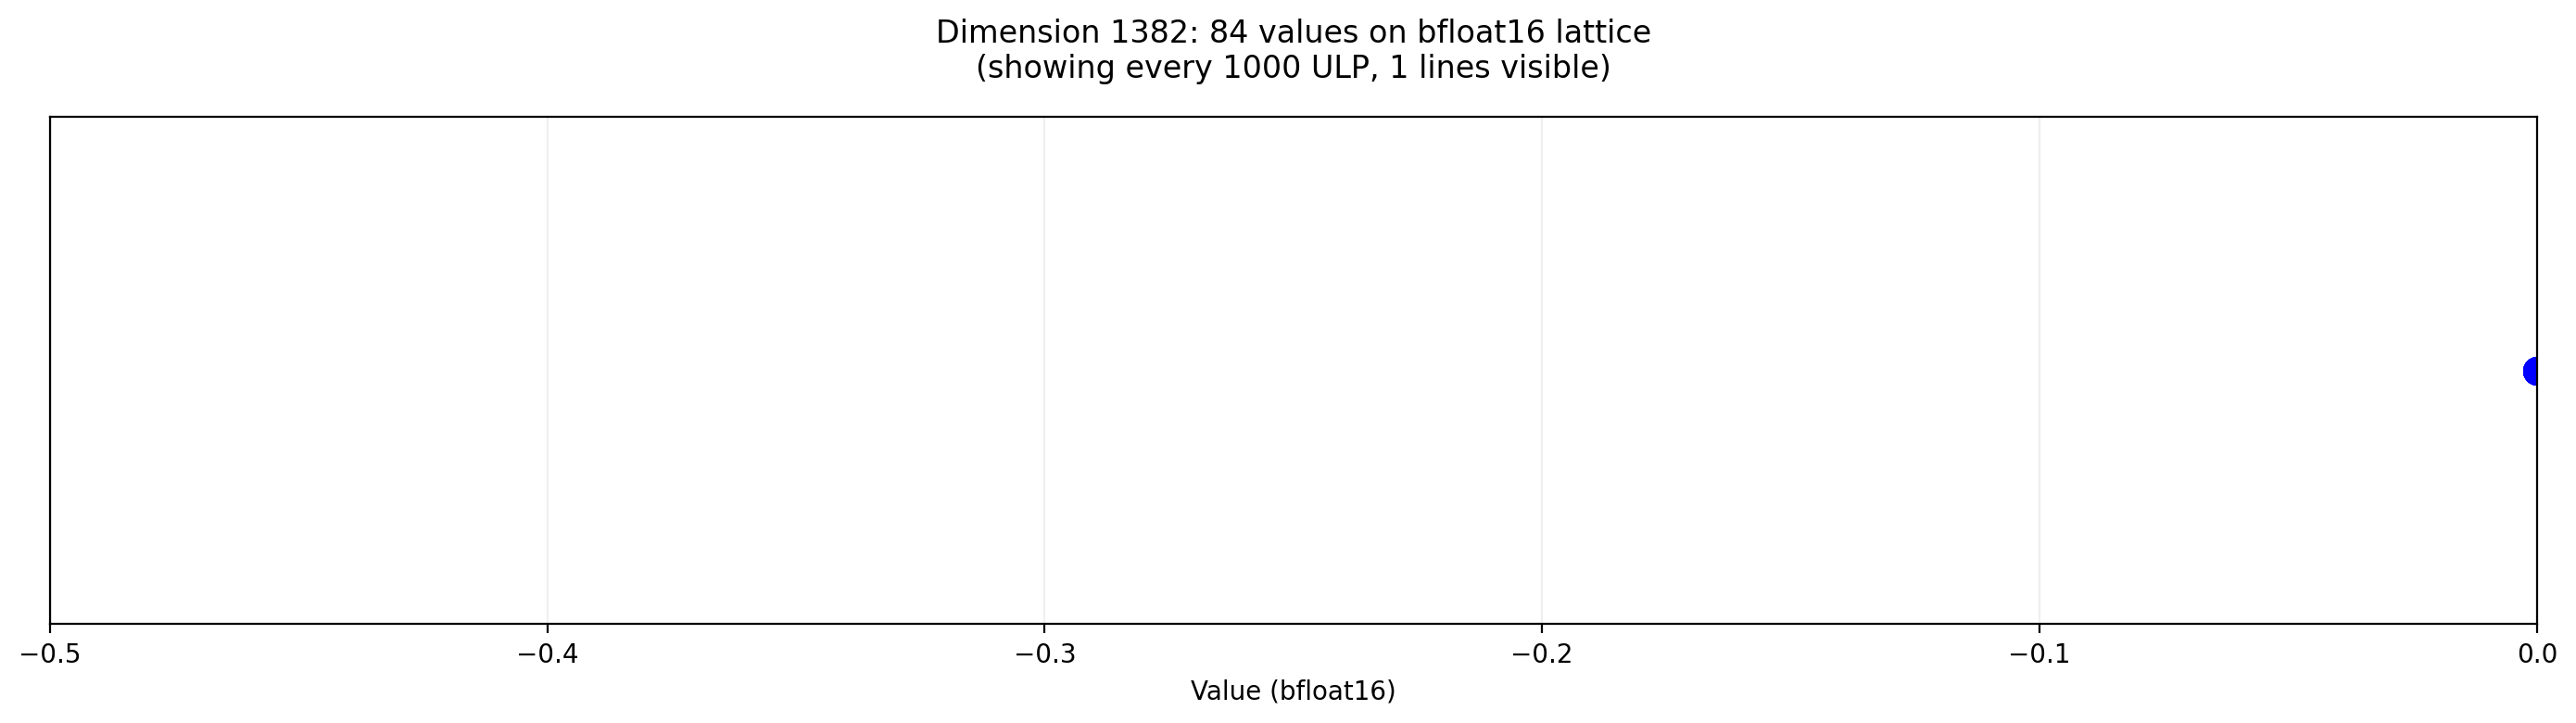


Visualization summary:
  Gray vertical lines: bfloat16 lattice (every 1000 ULP)
  Blue dots: actual cluster vector values
  X range: [-5.000000e-01, 0.000000e+00]


In [71]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=DPI)

# Plot lattice lines
for line_x in lattice_lines:
    ax.axvline(line_x, color='gray', alpha=0.3, linewidth=0.5, zorder=1)

# Plot actual data points
ax.scatter(unique_values, np.zeros_like(unique_values), 
           s=POINT_SIZE, c='blue', alpha=0.8, zorder=2)

# Styling
ax.set_xlim(x_min_plot, x_max_plot)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Value (bfloat16)')
ax.set_yticks([])
ax.set_title(f'Dimension {DIMENSION}: {len(unique_values)} values on bfloat16 lattice\n'
             f'(showing every {ULP_STRIDE} ULP, {len(lattice_lines)} lines visible)',
             pad=15)
ax.grid(True, alpha=0.2, axis='x')

plt.tight_layout()
plt.show()

print(f"\nVisualization summary:")
print(f"  Gray vertical lines: bfloat16 lattice (every {ULP_STRIDE} ULP)")
print(f"  Blue dots: actual cluster vector values")
print(f"  X range: [{x_min_plot:.6e}, {x_max_plot:.6e}]")

## Statistics: Data vs Lattice

In [72]:
# How many lattice points exist in the data range?
# Count by stepping ULP by ULP from min to max
current = torch.tensor(x_min_data).to(torch.bfloat16).to(torch.float32).item()
total_lattice_points = 0

while current <= x_max_data:
    total_lattice_points += 1
    ulp = bfloat16_ulp(current)
    current += ulp
    if total_lattice_points > 1000000:  # Safety
        break

occupancy = len(unique_values) / total_lattice_points if total_lattice_points > 0 else 0

print("="*60)
print("LATTICE OCCUPANCY")
print("="*60)
print(f"Data range: [{x_min_data:.6e}, {x_max_data:.6e}]")
print(f"Total lattice points in range: {total_lattice_points:,}")
print(f"Occupied lattice points: {len(unique_values)}")
print(f"Occupancy: {occupancy*100:.4f}%")
print(f"\nInterpretation:")
if occupancy < 0.01:
    print("  Extremely sparse - vectors occupy <1% of available lattice")
elif occupancy < 0.1:
    print("  Sparse - vectors occupy <10% of available lattice")
elif occupancy < 0.5:
    print("  Moderately dense - vectors occupy some lattice points")
else:
    print("  Dense - vectors occupy >50% of available lattice")
print("="*60)

LATTICE OCCUPANCY
Data range: [-1.204014e-05, 2.217293e-05]
Total lattice points in range: 1,000,001
Occupied lattice points: 84
Occupancy: 0.0084%

Interpretation:
  Extremely sparse - vectors occupy <1% of available lattice
